###**Importing Libraries and Stock Data from yfinance**

In [ ]:
#Importing libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [ ]:
#Importing monthly stock data
tickers = ['AAPL', 'KO']
df      = yf.download(tickers, start = '2012-01-01', end='2023-12-31', interval='1mo')['Adj Close']
df      = df.dropna()
df.head(5)

[*********************100%***********************]  2 of 2 completed


Ticker,AAPL,KO
Date,,
2012-01-01 00:00:00+00:00,13.767359,22.724363
2012-02-01 00:00:00+00:00,16.359890,23.508425
2012-03-01 00:00:00+00:00,18.082329,24.904924
2012-04-01 00:00:00+00:00,17.612730,25.870342
2012-05-01 00:00:00+00:00,17.424238,25.331381


### **Calculating the Percentage change**

In [ ]:
#Getting percentage returns
returns = df.pct_change().dropna()
returns.head(5)

Ticker,AAPL,KO
Date,,
2012-02-01 00:00:00+00:00,0.188310,0.034503
2012-03-01 00:00:00+00:00,0.105284,0.059404
2012-04-01 00:00:00+00:00,-0.025970,0.038764
2012-05-01 00:00:00+00:00,-0.010702,-0.020833
2012-06-01 00:00:00+00:00,0.010853,0.046300


### **Let's get the expected returns (average) of Apple and Coca-Cola**

In [ ]:
mean_returns = returns.mean()
print("Mean Returns:")
print(pd.DataFrame(mean_returns, columns=['Mean Return']))

Mean Returns:
        Mean Return
Ticker             
AAPL       0.021749
KO         0.007605


### **Calculating the Covariance between Apple and Coca-Cola**

In [ ]:
covariance = returns.cov()
print('Covariance Matrix:')
print(covariance)

Covariance Matrix:
Ticker      AAPL        KO
Ticker                    
AAPL    0.006421  0.001083
KO      0.001083  0.002135


###**Calculating the Weights for Apple and Coca-Cola for the Efficient Frontier**
\begin{align*}
w_A &\in [0, 1]\\  
w_C &= 1 - w_A
\end{align*}

In [ ]:
# Defining the number of portfolio points on the efficient frontier (arbitrary number)
num_portofolios = 100

# Generating an array of weights
weights_A = np.linspace(0,1,num=num_portofolios) ## Weight for Apple
weights_C = 1 - weights_A  ## Weight for Coca-Cola
weights_df = pd.DataFrame({'Weight_AAPL': weights_A, 'Weight_KO': weights_C}) ## Combining both weights into a single dataframe
weights_df.head(5)

,Weight_AAPL,Weight_KO
0,0.000000,1.000000
1,0.010101,0.989899
2,0.020202,0.979798
3,0.030303,0.969697
4,0.040404,0.959596


###**Calculating Portfolio Expected Returns**
$$
E[P] =w_A \times \text{average}_A + w_C \times \text{average}_C
$$

In [ ]:
weights_df['Portfolio_Return'] = (weights_df['Weight_AAPL']*mean_returns['AAPL']) + (weights_df['Weight_KO']*mean_returns['KO'])
weights_df.head(5)

,Weight_AAPL,Weight_KO,Portfolio_Return
0,0.000000,1.000000,0.007605
1,0.010101,0.989899,0.007748
2,0.020202,0.979798,0.007891
3,0.030303,0.969697,0.008034
4,0.040404,0.959596,0.008177


###**Calculating Portfolio Variance and Standard Deviation**
$$
\text{Port_var} = w_A^2 \times \text{var}_A + w_C^2 \times \text{var}_C + 2w_A w_C \times \text{cov}_{AC}
$$

$$
\text{Port_std} = (\text{Port_var})^2
$$

In [ ]:
var_AAPL    = covariance.loc['AAPL','AAPL'] ## individual variance AAPL
var_KO      = covariance.loc['KO','KO']     ## individual variance KO
cov_AAPL_KO = covariance.loc['AAPL','KO']   ## covariance between AAPL and KO

# Portfolio Variance
weights_df['Portfolio_Variance'] = (weights_df['Weight_AAPL']**2 * var_AAPL) + (weights_df['Weight_KO']**2 * var_KO) + \
 (2 * weights_df['Weight_AAPL'] * weights_df['Weight_KO'] * cov_AAPL_KO)

# Portfolio Standard Deviation
weights_df['Portfolio_StdDev'] = np.sqrt(weights_df['Portfolio_Variance'])

weights_df.head(5)

,Weight_AAPL,Weight_KO,Portfolio_Return,Portfolio_Variance,Portfolio_StdDev
0,0.000000,1.000000,0.007605,0.002135,0.046201
1,0.010101,0.989899,0.007748,0.002114,0.045978
2,0.020202,0.979798,0.007891,0.002095,0.045767
3,0.030303,0.969697,0.008034,0.002077,0.045570
4,0.040404,0.959596,0.008177,0.002060,0.045387


###**Plotting the Efficient Frontier**

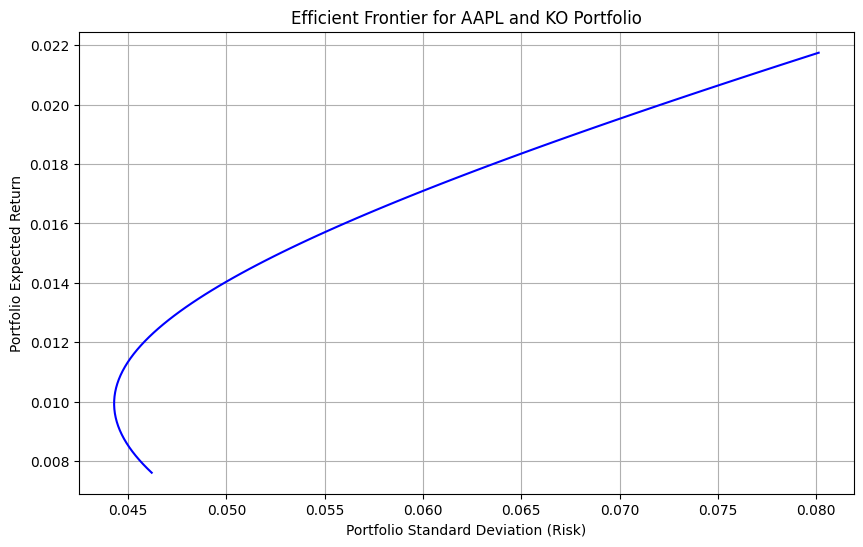

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(weights_df['Portfolio_StdDev'], weights_df['Portfolio_Return'], linestyle='-', color='b')
plt.title('Efficient Frontier for AAPL and KO Portfolio')
plt.xlabel('Portfolio Standard Deviation (Risk)')
plt.ylabel('Portfolio Expected Return')
plt.grid(True)
plt.show()

###**Defining Risk-Free Rate**

In [ ]:
annual_rf_rate  = 0.02 ## Setting annual risk-free rate at %2
monthly_rf_rate = (1 + annual_rf_rate) ** (1/12) - 1
print(f'Monthly Risk-Free Rate: {monthly_rf_rate:.6f}')

Monthly Risk-Free Rate: 0.001652


###**Creating a function that Maximizes Sharpe Ratio for a CML**
1. **Portfolio Return**

$$
R_p = \mathbf{w}^\top \boldsymbol{\mu}
$$

2. **Portfolio Standard Deviation**

$$
\sigma_p = \sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}
$$

3. **Sharpe Ratio**

$$
S = \frac{R_p - r_f}{\sigma_p}
$$

4. **Negative Sharpe Ratio**

$$
- S = -\left( \frac{R_p - r_f}{\sigma_p} \right)
$$

In [ ]:
def neg_sharpe_ratio(weights, mean_returns, covariance, rf_rate):
  portfolio_return = np.dot(weights, mean_returns)
  portfolio_std = np.sqrt(np.dot(weights.T, np.dot(covariance, weights)))
  sharpe_ratio = (portfolio_return - rf_rate) / portfolio_std  ##sharpe ratio function
  return -sharpe_ratio

###**Setting Constraints and Bounds**

In [ ]:
num_assets = len(mean_returns) ## determining the number of assets
initial_weigths = num_assets * [1. / num_assets, ] ## initial guess (equal weights, i.e. in our case this is 0.5)
constraints = ({'type' : 'eq', 'fun':lambda x: np.sum(x) - 1}) ## constraint: summ of weights = 1
bounds = tuple((0,1) for asset in range(num_assets)) ## bounds for weights: between 0 and 1 for each asset

###**Performing the Optmization**

In [ ]:
result = minimize(neg_sharpe_ratio, initial_weigths, args=(mean_returns, covariance, monthly_rf_rate), method='SLSQP', bounds=bounds, constraints=constraints)

###**Extracting the Optimal Weights**

In [ ]:
tangency_weights =result.x
print(f"Tangency Portfolio Weights:\nAAPL: {tangency_weights[0]:.4f}, KO: {tangency_weights[1]:.4f}")

Tangency Portfolio Weights:
AAPL: 0.6870, KO: 0.3130


###**Calculating Expected Return and Standard Deviation of the Tangency Portfolio**

In [ ]:
tangency_return = np.dot(tangency_weights, mean_returns)
tangency_std = np.sqrt(np.dot(tangency_weights.T, np.dot(covariance, tangency_weights)))
tangency_sharpe = (tangency_return - monthly_rf_rate) / tangency_std

print(f"Tangency Portfolio Expected Return: {tangency_return:.4f}")
print(f"Tangency Portfolio Standard Deviation: {tangency_std:.4f}")
print(f"Tangency Portfolio Sharpe Ratio: {tangency_sharpe: .4f}")

Tangency Portfolio Expected Return: 0.0173
Tangency Portfolio Standard Deviation: 0.0609
Tangency Portfolio Sharpe Ratio:  0.2574


In [ ]:
cml_std = np.linspace(0, tangency_std * 2, 100)
cml_return = monthly_rf_rate + (tangency_return - monthly_rf_rate) / tangency_std * cml_std

###**Plotting the Efficient Frontier Along with The CML**

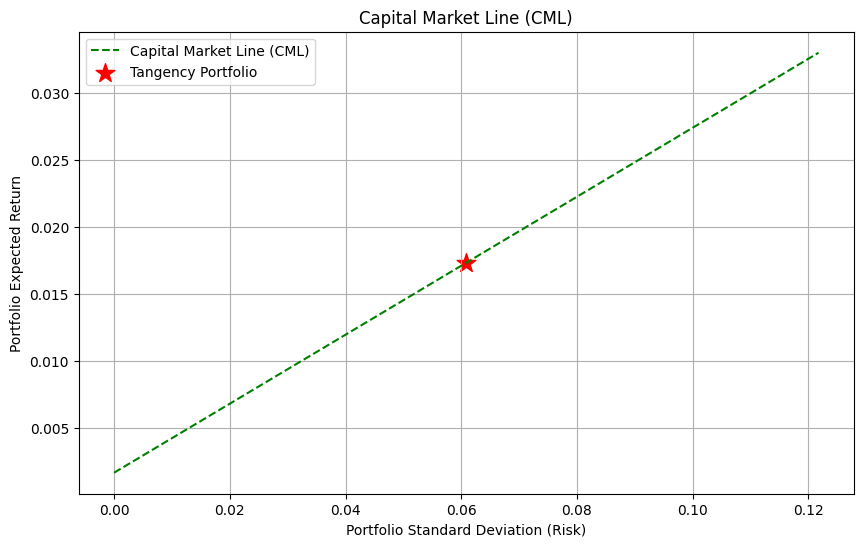

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(cml_std, cml_return, color='green', linestyle='--', label='Capital Market Line (CML)')
plt.scatter(tangency_std, tangency_return, color='red', marker='*', s=200, label='Tangency Portfolio')
plt.title('Capital Market Line (CML)')
plt.xlabel('Portfolio Standard Deviation (Risk)')
plt.ylabel('Portfolio Expected Return')
plt.legend()
plt.grid(True)
plt.show()

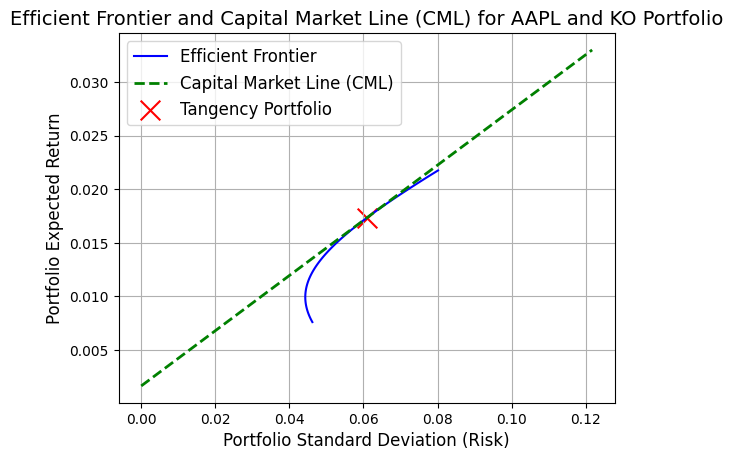

In [ ]:
plt.plot(weights_df['Portfolio_StdDev'], weights_df['Portfolio_Return'],
         linestyle='-', color='blue', label='Efficient Frontier')
plt.plot(cml_std, cml_return, color='green', linestyle='--', linewidth=2, label='Capital Market Line (CML)')
plt.scatter(tangency_std, tangency_return, color='red', marker='x', s=200, label='Tangency Portfolio')
plt.title('Efficient Frontier and Capital Market Line (CML) for AAPL and KO Portfolio', fontsize=14)
plt.xlabel('Portfolio Standard Deviation (Risk)', fontsize=12)
plt.ylabel('Portfolio Expected Return', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

*The efficient frontier looks very small compared to the CML, so let's re-scale it

###**Let's Define the CML Points Based on the Efficient Frontier**

In [ ]:
cml_std = np.linspace(0, tangency_std * 1.5, 100)  ## Change as desired
cml_return = monthly_rf_rate + tangency_sharpe * cml_std

###**Re-Plotting the Efficient Frontier Along with The CML**

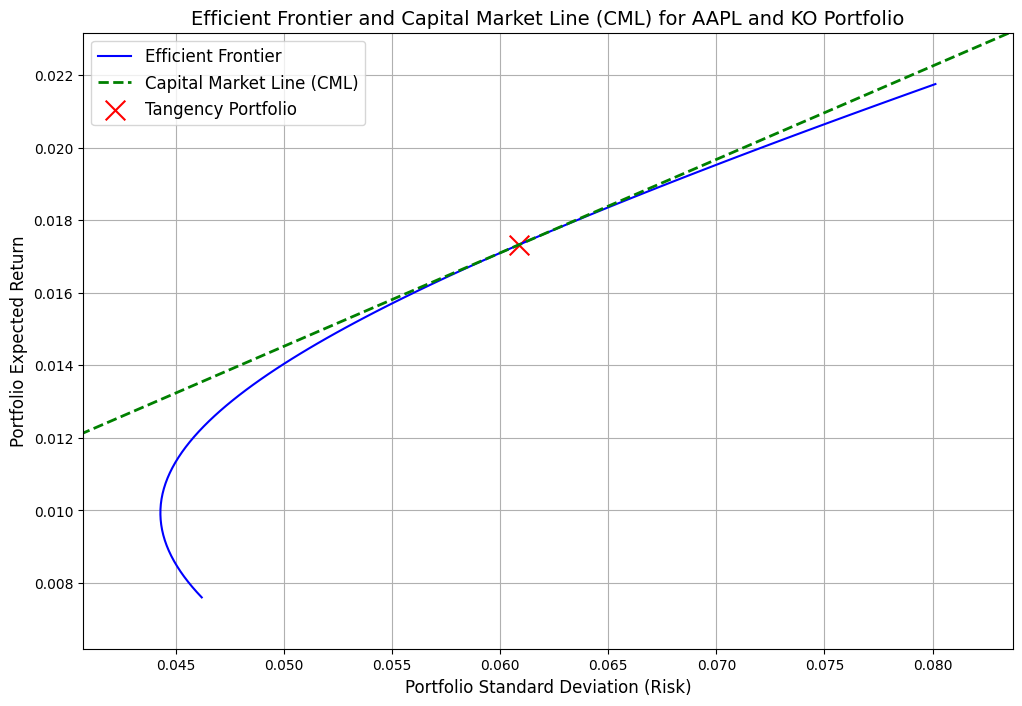

In [ ]:
plt.figure(figsize=(12, 8))

# Plot the Efficient Frontier
plt.plot(weights_df['Portfolio_StdDev'], weights_df['Portfolio_Return'],
         linestyle='-', color='blue', label='Efficient Frontier')

# Plot the Capital Market Line (CML)
plt.plot(cml_std, cml_return, color='green', linestyle='--', linewidth=2, label='Capital Market Line (CML)')

# Highlight the Tangency Portfolio with an 'x' marker
plt.scatter(tangency_std, tangency_return, color='red', marker='x', s=200, label='Tangency Portfolio')

# Adjust the plot limits to zoom in on the Efficient Frontier
# Find the range of the Efficient Frontier
min_std = weights_df['Portfolio_StdDev'].min()
max_std = weights_df['Portfolio_StdDev'].max()
min_return = weights_df['Portfolio_Return'].min()
max_return = weights_df['Portfolio_Return'].max()

# Add some padding to the limits
std_padding = (max_std - min_std) * 0.1
return_padding = (max_return - min_return) * 0.1

# Set the x and y limits
plt.xlim(min_std - std_padding, max_std + std_padding)
plt.ylim(min_return - return_padding, max_return + return_padding)

# Titles and Labels
plt.title('Efficient Frontier and Capital Market Line (CML) for AAPL and KO Portfolio', fontsize=14)
plt.xlabel('Portfolio Standard Deviation (Risk)', fontsize=12)
plt.ylabel('Portfolio Expected Return', fontsize=12)

# Legend and Grid
plt.legend(fontsize=12)
plt.grid(True)

# Show Plot
plt.show()